In [183]:
import gym
from gym import Env, spaces

import numpy as np
import seaborn as sns
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

Configurar o Enxame


In [184]:
num_drones = 6
limite_y = 80
limite_x = 100

alcance_comunicacao_jammer = 25
alcance_comunicacao_nos=500
B_Hz = 2.4e9  # Largura de banda

# Posições estáticas dos drones
posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50]])

posicao_jammer = np.array([38,50])



ENCONTRAR VIZINHOS E NOS AFETADOS

In [185]:
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
# Preparando a figura

def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer

vizinhos = encontra_vizinhos(posicoes, alcance_comunicacao_nos)
afetados_pelo_jammer = verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)

print('Nos Vizinhos:', vizinhos)
print('Nos Afetados Jammer:', afetados_pelo_jammer)

Nos Vizinhos: {0: [1, 2, 3, 4, 5], 1: [0, 2, 3, 4, 5], 2: [0, 1, 3, 4, 5], 3: [0, 1, 2, 4, 5], 4: [0, 1, 2, 3, 5], 5: [0, 1, 2, 3, 4]}
Nos Afetados Jammer: [1, 4, 5]


CALCULA AS POTENCIAS DE RECEÇÃO

In [186]:
Ptx_dBm = 30 
Gtx_dBi = Grx_dBi =0       
f = 2.4e9 
d0=1
gamma=2


def calcular_Prx_dB(Ptx_dBm, Gtx_dBi, Grx_dBi, d,d0,gamma, f):
    """
    Calcula a potência do sinal recebido usando a equação de Friis.
    """
    c = 3e8  # Velocidade da luz em m/s
    lambda_m = c / f  # Comprimento de onda
    L = (4 * np.pi * d / lambda_m)**2
    Prx_dBm = Ptx_dBm + Gtx_dBi + Grx_dBi - 10 * np.log10(L)
    return Prx_dBm


def calcular_potencia_recebida_vizinhos(vizinhos, posicoes):
    prx_resultados = {}
    for drone, seus_vizinhos in vizinhos.items():
        for vizinho in seus_vizinhos:
            d = distancia(posicoes[drone], posicoes[vizinho])
            prx = calcular_Prx_dB(Ptx_dBm, Gtx_dBi, Grx_dBi, d,d0,gamma, f)
            prx_resultados[f"Drone {drone} para Vizinho {vizinho}"] = prx
    return prx_resultados

prx_resultados = calcular_potencia_recebida_vizinhos(vizinhos, posicoes)
print('resultadosPRX',prx_resultados)

# Exibir os resultados
for chave, prx in prx_resultados.items():
    print(f"{chave}: Prx = {prx:.2f} dBm")
    
    




resultadosPRX {'Drone 0 para Vizinho 1': -35.20473545739759, 'Drone 0 para Vizinho 2': -40.084908682649896, 'Drone 0 para Vizinho 3': -42.82895910119353, 'Drone 0 para Vizinho 4': -44.34351982030488, 'Drone 0 para Vizinho 5': -41.9660929468175, 'Drone 1 para Vizinho 0': -35.20473545739759, 'Drone 1 para Vizinho 2': -42.513444117519214, 'Drone 1 para Vizinho 3': -38.17513058670936, 'Drone 1 para Vizinho 4': -41.36218366377206, 'Drone 1 para Vizinho 5': -40.16592816687337, 'Drone 2 para Vizinho 0': -40.084908682649896, 'Drone 2 para Vizinho 1': -42.513444117519214, 'Drone 2 para Vizinho 3': -45.84954363134672, 'Drone 2 para Vizinho 4': -45.315847705880756, 'Drone 2 para Vizinho 5': -41.053147886011615, 'Drone 3 para Vizinho 0': -42.82895910119353, 'Drone 3 para Vizinho 1': -38.17513058670936, 'Drone 3 para Vizinho 2': -45.84954363134672, 'Drone 3 para Vizinho 4': -36.894450636724926, 'Drone 3 para Vizinho 5': -41.0428034313733, 'Drone 4 para Vizinho 0': -44.34351982030488, 'Drone 4 para 

CALCULAR AS CAPACIDADES

Considero o ruido apenas o efeito dos outros drones que não estão a comunicar diretamente com o meu nó 

Atribuí um peso de apenas 30% da potencia de receção caso o drone estivesse a apontar diretamente

In [187]:
def calcular_capacidade_canal(Prx_dBm, B_Hz, N_dBm):
    """
    Calcula a capacidade do canal usando o teorema de Shannon-Hartley.

    :param Prx_dBm: Potência do sinal recebido em dBm.
    :param B_Hz: Largura de banda do canal em Hertz.
    :param N_dBm: Potência do ruído em dBm.
    :return: Capacidade do canal em bits por segundo.
    """
    # Convertendo potências de dBm para Watts
    Prx_W = 10**((Prx_dBm - 30) / 10)
    N_W = 10**((N_dBm - 30) / 10)

    # Calculando a razão sinal-ruído (SNR)
    SNR = Prx_W / N_W

    # Calculando a capacidade do canal
    C_bps = B_Hz * np.log2(1 + SNR)
    return C_bps



def calcular_potencia_ruido(prx_resultados, rota_atual, B_Hz):
    # Inicializa a potência total de ruído em Watts
    potencia_ruido_total_W = 0

    # Determina os drones envolvidos na comunicação atual
    drones_envolvidos = rota_atual

    # Itera sobre todos os resultados de Prx para calcular o ruído
    for link, Prx_dBm in prx_resultados.items():
        partes = link.split()
        transmissor = int(partes[1])
        receptor = int(partes[4])

        # Verifica se o drone não está envolvido na comunicação atual
        if transmissor not in drones_envolvidos and receptor not in drones_envolvidos:
            # Converte a potência de dBm para Watts e aplica o fator de redução de 10%
            Prx_W = 10 ** ((Prx_dBm - 30) / 10) * 0.3
            potencia_ruido_total_W += Prx_W

    # Converte a potência total de ruído de volta para dBm se houver ruído calculado
    if potencia_ruido_total_W > 0:
        N_dBm = 10 * np.log10(potencia_ruido_total_W) + 30
    else:
        # Assume um valor padrão de ruído se não houver outros drones contribuindo
        N_dBm = -100  # Um valor padrão de ruído em dBm

    return N_dBm

def calcular_capacidades_canais(prx_resultados, posicoes, B_Hz):
    # Armazena as capacidades de canal para cada link na rota
    capacidades = []

    for drone, seus_vizinhos in vizinhos.items():
        for vizinho in seus_vizinhos:
        # Certifique-se de que o formato da chave aqui corresponda ao formato usado ao preencher prx_resultados
            chave_prx = f'Drone {drone} para Vizinho {vizinho}'
        # Verifica se a chave existe no dicionário para evitar KeyError
            if chave_prx in prx_resultados:
                Prx_dBm = prx_resultados[chave_prx]
                # print(Prx_dBm)
                # Calcular a potência do ruído dos outros drones
            N_dBm = calcular_potencia_ruido(prx_resultados, [drone, vizinho], B_Hz)

                # Se a potência do ruído não puder ser calculada, assuma um valor padrão
            if N_dBm is None:
                N_dBm = -100  # valor padrão em dBm para a potência de ruído

                # Calcular a capacidade do canal
            capacidade_bps = calcular_capacidade_canal(Prx_dBm, B_Hz, N_dBm)
            capacidade_bps=capacidade_bps / 1e6
            capacidades.append((drone, vizinho, capacidade_bps))

    return capacidades



capacidades = calcular_capacidades_canais(prx_resultados, posicoes, B_Hz)

bottleneck_bps = float('inf')

# Identificar a capacidade mais baixa ao longo da rota
for transmissor, receptor, capacidade_bps in capacidades:
    print(f"Capacidade do canal entre Drone {transmissor} e Drone {receptor}: {capacidade_bps:.2f} Mbps")
    if capacidade_bps < bottleneck_bps:
        bottleneck_bps = capacidade_bps

# Verifica se um bottleneck foi encontrado
if bottleneck_bps < float('inf'):
    print(f"O bottleneck da rota é: {bottleneck_bps:.2f} Mbps")
else:
    print("Não foi possível determinar o bottleneck.")


capacidade_dict = {(transmissor, receptor): capacidade_bps for transmissor, receptor, capacidade_bps in capacidades}

print(capacidade_dict)

Capacidade do canal entre Drone 0 e Drone 1: 2119.18 Mbps
Capacidade do canal entre Drone 0 e Drone 2: 656.21 Mbps
Capacidade do canal entre Drone 0 e Drone 3: 542.87 Mbps
Capacidade do canal entre Drone 0 e Drone 4: 410.01 Mbps
Capacidade do canal entre Drone 0 e Drone 5: 619.23 Mbps
Capacidade do canal entre Drone 1 e Drone 0: 2119.18 Mbps
Capacidade do canal entre Drone 1 e Drone 2: 490.31 Mbps
Capacidade do canal entre Drone 1 e Drone 3: 1457.07 Mbps
Capacidade do canal entre Drone 1 e Drone 4: 926.65 Mbps
Capacidade do canal entre Drone 1 e Drone 5: 1062.16 Mbps
Capacidade do canal entre Drone 2 e Drone 0: 656.21 Mbps
Capacidade do canal entre Drone 2 e Drone 1: 490.31 Mbps
Capacidade do canal entre Drone 2 e Drone 3: 194.53 Mbps
Capacidade do canal entre Drone 2 e Drone 4: 220.73 Mbps
Capacidade do canal entre Drone 2 e Drone 5: 512.18 Mbps
Capacidade do canal entre Drone 3 e Drone 0: 542.87 Mbps
Capacidade do canal entre Drone 3 e Drone 1: 1457.07 Mbps
Capacidade do canal entre 

DIREÇÕES AFETADAS PELO JAMMER

In [188]:
def calcular_direcao_feixe_jammer(posicao_jammer, posicoes, afetados_pelo_jammer):
    direcoes = {}
    for i in afetados_pelo_jammer:
        dx = posicoes[i][0] - posicao_jammer[0]
        dy = posicoes[i][1] - posicao_jammer[1]
        angulo_radianos = np.arctan2(dy, dx)
        angulo_graus = np.degrees(angulo_radianos)
        # Normaliza o ângulo para o intervalo de 0 a 360 graus
        angulo_graus = (angulo_graus + 360) % 360
        direcoes[i] = angulo_graus
    return direcoes

# Calcula a direção do feixe do jammer para os nós afetados
direcoes_feixe_jammer = calcular_direcao_feixe_jammer(posicao_jammer, posicoes, afetados_pelo_jammer)

# Exibe os resultados
for no, direcao in direcoes_feixe_jammer.items():
    print(f"Direção do feixe do jammer para o nó {no}: {direcao:.2f} graus")

Direção do feixe do jammer para o nó 1: 185.71 graus
Direção do feixe do jammer para o nó 4: 73.07 graus
Direção do feixe do jammer para o nó 5: 0.00 graus


INTERVALO ANGULAR CRITICO

In [189]:
def calcular_intervalo_angular_critico(posicao_jammer, posicoes, afetados_pelo_jammer):
    intervalos = {}
    for i in afetados_pelo_jammer:
        dx = posicoes[i][0] - posicao_jammer[0]
        dy = posicoes[i][1] - posicao_jammer[1]
        angulo_radianos = np.arctan2(dy, dx)
        angulo_graus = np.degrees(angulo_radianos)

        # Normaliza o ângulo para o intervalo de 0 a 360 graus
        angulo_graus = (angulo_graus + 360) % 360
        intervalo_min = (angulo_graus - 30 + 360) % 360  # Subtrai 30 graus e normaliza
        intervalo_max = (angulo_graus + 30) % 360  # Adiciona 30 graus e normaliza

        intervalos[i] = (intervalo_min, intervalo_max)
    return intervalos

# Calcula o intervalo angular crítico para os nós afetados
intervalos_angular_critico = calcular_intervalo_angular_critico(posicao_jammer, posicoes, afetados_pelo_jammer)

# Exibe os resultados
for no, intervalo in intervalos_angular_critico.items():
    print(f"Angulo crítico para o nó {no}: {intervalo[0]:.2f}° a {intervalo[1]:.2f}°")


Angulo crítico para o nó 1: 155.71° a 215.71°
Angulo crítico para o nó 4: 43.07° a 103.07°
Angulo crítico para o nó 5: 330.00° a 30.00°


VIZUALIZAR O ENXAME

In [190]:
fig = go.Figure()

# Adiciona os drones
for i in range(num_drones):
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0]],
        y=[posicoes[i, 1]],
        mode='markers+text',
        marker=dict(size=10, color='orange' if i in afetados_pelo_jammer else 'blue'),
        text=str(i),
        textposition="bottom center",
        showlegend=False  # Oculta esses rastros da legenda
    ))

# Adiciona o jammer
fig.add_trace(go.Scatter(
    x=[posicao_jammer[0]],
    y=[posicao_jammer[1]],
    mode='markers',
    marker=dict(size=12, color='red'),
    name='Jammer'
))

# Adiciona rastros para a legenda
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='blue'), name="Nó não afetado"))
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='orange'), name="Nó afetado"))
# O Jammer já está adicionado com a legenda correta

# Configurações do gráfico
fig.update_layout(
    title="Simulação de Modelo de Comunicação Wireless entre Drones",
    xaxis=dict(range=[0, limite_x], autorange=False),
    yaxis=dict(range=[0, limite_y], autorange=False),
    legend_title_text='Legenda',
    legend=dict(traceorder='normal', itemsizing='constant')
)

fig.show()

OPEN AI GYM

In [191]:
class UAVCommunicationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=6, area_size=(100, 100)):
        super(UAVCommunicationEnv, self).__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.posicoes = posicoes
        self.posicao_jammer = posicao_jammer
        self.afetados_pelo_jammer=afetados_pelo_jammer
        self.prx_resultados=prx_resultados
        self.B_Hz = B_Hz  # Largura de banda
        self.capacidade_bps = capacidade_dict
        

        self.action_space = spaces.MultiDiscrete([num_uavs] * num_uavs)
        
        # O estado agora inclui somente as direções de comunicação (índices dos UAVs-alvo)
        self.observation_space = spaces.Discrete(num_uavs ** num_uavs)
        
        self.ultima_acao = np.zeros(num_uavs, dtype=int)  # Inicializa com todos os UAVs não comunicando

    def step(self, action):
        # Ajuste de ação para garantir que nenhum drone esteja se comunicando consigo mesmo
        for i in range(self.num_uavs):
            while action[i] == i:
                action[i] = np.random.choice([x for x in range(self.num_uavs) if x != i])

        self.ultima_acao = action

        # Inicializar variáveis para armazenar a capacidade média e a capacidade mínima
        capacidade_media = 0
        capacidade_min = float('inf')  # Inicia com um valor muito alto para encontrar o mínimo

        # Lista para coletar todas as capacidades dos links definidos pela ultima_acao
        capacidades_selecionadas = []

        for i, destino in enumerate(action):
            # A chave é uma tupla de (transmissor, receptor)
            chave = (i, destino)
            
            # Verifica se a chave existe no dicionário de capacidades
            if chave in self.capacidade_bps:
                capacidade = self.capacidade_bps[chave]
                capacidades_selecionadas.append(capacidade)
            else:
                # Trata casos onde a chave não existe
                capacidades_selecionadas.append(0)

        # Calcular a capacidade média e mínima se houver capacidades válidas na lista
        if capacidades_selecionadas:
            capacidade_media = np.mean(capacidades_selecionadas)
            capacidade_min = np.min(capacidades_selecionadas)

        # Calcular a recompensa baseada na capacidade média e mínima dos links selecionados
        recompensa = 0.5 * capacidade_media + 0.5 * capacidade_min

        done = False
        info = {
            'capacidade_media': capacidade_media,
            'capacidade_min': capacidade_min,
            'capacidades_selecionadas': capacidades_selecionadas  # Opcional: para debug ou informação adicional
        }

        return self.ultima_acao, recompensa, done, info

    
    
    def render(self, mode='human'):
            
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(9, 4))

        # Marca para garantir que os labels da legenda sejam adicionados apenas uma vez
        label_afetado_added = False
        label_nao_afetado_added = False

        for i, pos in enumerate(self.posicoes):
            if i in self.afetados_pelo_jammer:
                if not label_afetado_added:
                    ax.scatter(pos[0], pos[1], color='orange', s=100, label='Drone Afetado', alpha=0.7)
                    label_afetado_added = True
                else:
                    ax.scatter(pos[0], pos[1], color='orange', s=100, alpha=0.7)
            else:
                if not label_nao_afetado_added:
                    ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone Não Afetado', alpha=0.7)
                    label_nao_afetado_added = True
                else:
                    ax.scatter(pos[0], pos[1], color='blue', s=100, alpha=0.7)
            ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center')
            
        ax.legend()
        # Desenha as linhas de comunicação e setas
        for i, destino in enumerate(self.ultima_acao):
            if destino != i:
                pos_inicio = self.posicoes[i]
                pos_final = self.posicoes[destino]
                ax.plot([pos_inicio[0], pos_final[0]], [pos_inicio[1], pos_final[1]], 'b--', alpha=0.5)  # Linha tracejada
                # Calcula a direção para a seta
                direcao = pos_final - pos_inicio
                direcao_norm = direcao / np.linalg.norm(direcao)
                # Define o comprimento da seta
                comprimento_seta = 5
                ponto_final_seta = pos_inicio + direcao_norm * comprimento_seta
                # Desenha a seta
                ax.arrow(pos_inicio[0], pos_inicio[1], ponto_final_seta[0] - pos_inicio[0], ponto_final_seta[1] - pos_inicio[1], 
                        head_width=2, head_length=2, fc='b', ec='b')

        # Desenha o jammer
        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')
        
        # Configurações finais do gráfico
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        ax.legend()
        plt.title('Comunicação UAV com Jammer')
        plt.show()

    


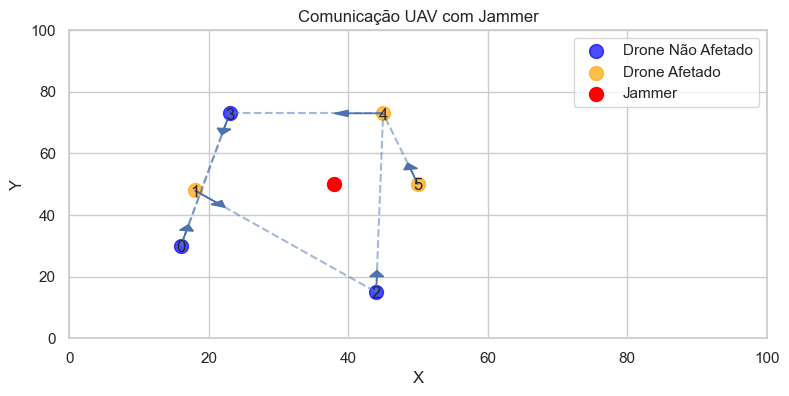

[3 2 4 0 3 4]
{'capacidade_media': 737.880056526489, 'capacidade_min': 220.7281127874874, 'capacidades_selecionadas': [542.8673036395667, 490.3087364198001, 220.7281127874874, 542.8673036395667, 1382.8127032426964, 1247.696179429817]}


In [192]:
env = UAVCommunicationEnv()

state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Exemplo: escolha uma ação aleatoriamente
    state, reward, done, info = env.step(action)
    env.render()  # Chame render a cada passo para visualizar
    print(state)
    print(info)
    done=True
